# AllConv-DenseNet

This model takes the basic architecture of the [all convolutional net](https://arxiv.org/abs/1412.6806) and adds [dense shortcuts](https://arxiv.org/abs/1608.06993).

The regualar (no shortcuts) version and the residual shortcut version are trained in the notebook 'AllConv-Net vs. AllConv-ResNet'.

In [1]:
import os

import numpy as np
from numpy.random import choice
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
from torchvision import datasets
import torchvision

import sys
sys.path.append('../utils')
sys.path.append('../models')
import utils
import all_conv_dense_net

In [2]:
data_dir = '../data'

# values for normalisation
channel_means = (0.5071, 0.4865, 0.4409)
channel_standard_devs = (0.2673, 0.2564, 0.2762)

transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(channel_means, channel_standard_devs)
])
batchsize=64

test_set = datasets.CIFAR100(data_dir, train=False, transform=transformation, download=True)
test_loader = DataLoader(test_set, batch_size=batchsize)

rest = datasets.CIFAR100(data_dir, train=True, transform=transformation, download=True)
train_loader, validation_loader = utils.train_validation_split(rest, fraction=0.1, batchsize=batchsize)

print(f'training batches: {len(train_loader)}')
print(f'validation batches: {len(validation_loader)}')
print(f'test batches: {len(test_loader)}')
print(f'batch size: {batchsize}')

Files already downloaded and verified
Files already downloaded and verified
training batches: 704
validation batches: 79
test batches: 157
batch size: 64


In [3]:
print('MODEL: AllConv-DenseNet')
net = all_conv_dense_net.AllConvDenseNet(g=64)
print(f'parameters: {utils.count_parameters(net, in_millions=True):.2f} million\n')

optimizer = torch.optim.SGD(net.parameters(),
                            lr=0.1,
                            momentum=0.9,
                            weight_decay=0.00002
                           )
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.75, patience=5, threshold=0.01, verbose=True)

utils.train_model(net, train_loader, validation_loader, optimizer, scheduler, max_epoch=250)

MODEL: AllConv-DenseNet
parameters: 1.05 million

epoch	training-CE	validation-CE	validation-accuracy (%)
0	4.42		4.18		12.50
1	4.15		3.87		12.50
2	3.93		3.59		25.00
3	3.73		3.31		25.00
4	3.54		3.07		50.00
5	3.37		2.94		25.00
6	3.22		2.78		25.00
7	3.08		2.61		37.50
8	2.99		2.49		50.00
9	2.88		2.34		62.50
10	2.79		2.24		62.50
11	2.72		2.14		50.00
12	2.64		2.08		75.00
13	2.60		2.00		50.00
14	2.53		1.95		62.50
15	2.47		1.91		75.00
16	2.42		1.88		75.00
17	2.39		1.87		87.50
18	2.36		1.81		62.50
19	2.29		1.84		75.00
20	2.27		1.77		75.00
21	2.22		1.69		75.00
22	2.19		1.71		62.50
23	2.15		1.66		87.50
24	2.15		1.68		50.00
25	2.13		1.62		62.50
26	2.10		1.66		50.00
27	2.08		1.65		75.00
28	2.06		1.62		75.00
29	2.03		1.61		87.50
30	2.00		1.57		62.50
31	2.00		1.57		62.50
32	1.96		1.55		75.00
33	1.96		1.60		62.50
34	1.94		1.58		87.50
35	1.92		1.56		75.00
36	1.90		1.55		62.50
37	1.90		1.55		75.00
Epoch    38: reducing learning rate of group 0 to 7.5000e-02.
38	1.89		1.55		62.50
39	1.81		1.48		75.00
40

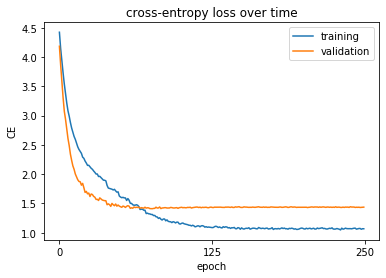


Evaluation on the test-set:
mean batch cross-entropy loss: 1.43
accuracy: 62.91


In [5]:
utils.plot_error_curves(utils.error_stats, error_name='cross-entropy loss')

net.load_state_dict(torch.load(f'{net.__class__.__name__}_best.pt'))
utils.test_set_evaluation(net.cuda(), test_loader, just_print=True)